<a href="https://colab.research.google.com/github/facundocarballo/ProgramacionConcurrente/blob/main/TP3/CPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIFO - PIPE con Nombre

Este sistema cuenta con 2 procesos, un proceso que hace de "Servidor" y otro proceso que hace de "Cliente".

El cliente envia una cierta cantidad de numeros (puede enviar cuantos quiera) separados por '-'. El Servidor, recibe esa informacion y la procesa. Obteniendo estos datos:
- Promedio
- Minimo
- Maximo
- Suma
- Cantidad de numeros enviados

La siguiente imagen representa como funciona este sistema de comunicacion de procesos.

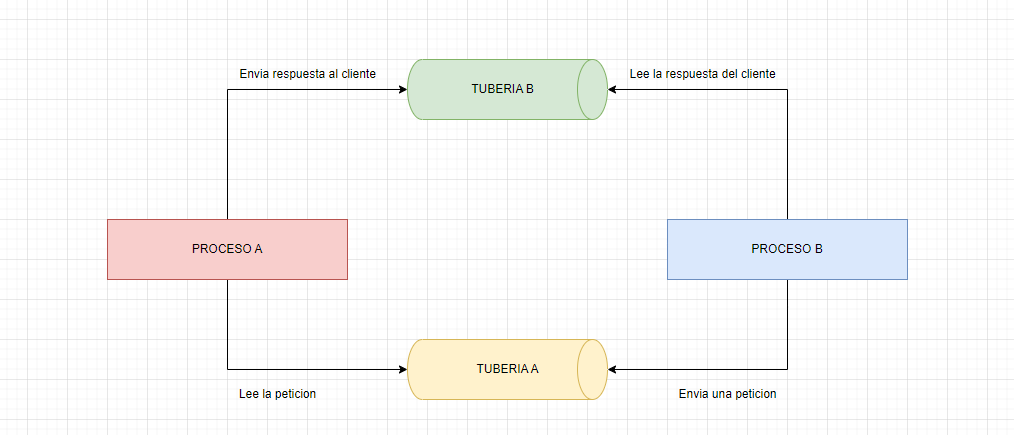

**El Proceso A es el Servidor.**

**El Proceso B es el Cliente.**

El Cliente utiliza la Tuberia "A" para escribir su peticion.

El Servidor utiliza la Tuberia "A" para leer la peticion del Cliente.

El Servidor utiliza la Tuberia "B" para escribir la respuesta al Cliente.

El Cliente utiliza la Tuberia "B" para leer la respuesta del Servidor.

# Servidor

In [42]:
%%writefile server.cpp
#include <fcntl.h>
#include <sys/stat.h>
#include <unistd.h>

#include <iostream>

#define FIFO_PERMISSIONS 0666
#define MKFIFO_ERROR -1
#define INFO_MAX_INIT_VALUE 0
#define INFO_MIN_INIT_VALUE 2147483647
#define INFO_AVERAGE_INIT_VALUE 0
#define INFO_ADITION_INIT_VALUE 0

typedef struct t_info 
{
  float average;
  int max, min, addition, amount;
} Info;

void InitInfo(Info*, int*);
bool TryChangeMax(Info*, int*);
bool TryChangeMin(Info*, int*);
void IncrementAddition(Info*, int*);
void SetAverage(Info*);
void MakeDeamon();

int fileA, fileB, num;
const char* kFifoA = "/tmp/TP3_M3-A1";
const char* kFifoB = "/tmp/TP3_M3-B1";
Info info;

int main() 
{
  MakeDeamon();
  
  if (mkfifo(kFifoB, FIFO_PERMISSIONS) == MKFIFO_ERROR) 
  {
    perror("Error al crear el FIFO.");
    return EXIT_FAILURE;
  }

  if (mkfifo(kFifoA, FIFO_PERMISSIONS) == MKFIFO_ERROR) 
  {
    perror("Error al crear el FIFO.");
    return EXIT_FAILURE;
  }

  fileA = open(kFifoA, O_RDONLY);
  fileB = open(kFifoB, O_WRONLY);

  read(fileA, &num, sizeof(int));
  InitInfo(&info, &num);
  for (int i = 0; i < info.amount; i++) 
  {
    read(fileA, &num, sizeof(int));
    TryChangeMax(&info, &num);
    TryChangeMin(&info, &num);
    IncrementAddition(&info, &num);
  }
  SetAverage(&info);
  write(fileB, &info, sizeof(Info));

  close(fileA);
  close(fileB);
  unlink(kFifoB);
  unlink(kFifoA);

  return EXIT_SUCCESS;
}

void MakeDeamon()
{
  int pid = fork();
  if (pid < 0)
  {
    perror("Fork error.");
  }
  else if (pid > 0)
  {
    exit(EXIT_SUCCESS);
  }
}

void InitInfo(Info* info, int* amount) 
{
  info->addition = INFO_ADITION_INIT_VALUE;
  info->amount = *amount;
  info->average = INFO_AVERAGE_INIT_VALUE;
  info->max = INFO_MAX_INIT_VALUE;
  info->min = INFO_MIN_INIT_VALUE;
}

bool TryChangeMax(Info* info, int* num) 
{
  if (*num > info->max) {
    info->max = *num;
    return true;
  }

  return false;
}

bool TryChangeMin(Info* info, int* num) 
{
  if (*num < info->min) {
    info->min = *num;
    return true;
  }

  return false;
}

void IncrementAddition(Info* info, int* num) 
{ 
    info->addition += *num; 
}

void SetAverage(Info* info) 
{
  info->average = (float)info->addition / (float)info->amount;
}

Overwriting server.cpp


# Cliente

In [43]:
%%writefile client.cpp
#include <fcntl.h>
#include <sys/stat.h>
#include <unistd.h>

#include <iostream>

#define FIFO_PERMISSIONS 0666
#define POS_NUMBERS 1
#define STR_INITIAL_POS 0
#define STR_NEXT_POS 1
#define CHAR_SEPARATOR '-'

typedef struct t_info 
{
  float average;
  int max, min, addition, amount;
} Info;

int fileA, fileB, num, amount = 1;
const char* kFifoA = "/tmp/TP3_M3-A1";
const char* kFifoB = "/tmp/TP3_M3-B1";
Info info;

void SendAmountOfNumbers(std::string msg);
void SendNumbers(std::string msg);
void PrintInfo(Info* info);
void Help();

int main(int argc, char* argv[]) 
{
  if (argc != 2)
  {
    Help();
    return EXIT_FAILURE;
  }

  fileA = open(kFifoA, O_WRONLY);
  fileB = open(kFifoB, O_RDONLY);

  // Send data
  SendAmountOfNumbers(argv[POS_NUMBERS]);
  SendNumbers(argv[POS_NUMBERS]);

  // Receive data.
  read(fileB, &info, sizeof(Info));

  PrintInfo(&info);

  close(fileB);
  close(fileA);
}

void SendNumbers(std::string msg) 
{
  int pos = msg.find(CHAR_SEPARATOR);
  while (pos != std::string::npos) 
  {
    num = stoi(msg.substr(STR_INITIAL_POS, pos));
    write(fileA, &num, sizeof(int));
    msg = msg.substr(pos + STR_NEXT_POS);
    pos = msg.find(CHAR_SEPARATOR);
  }
  num = stoi(msg);
  write(fileA, &num, sizeof(int));
}

void SendAmountOfNumbers(std::string msg) 
{
  int pos = msg.find(CHAR_SEPARATOR);
  while (pos != std::string::npos) 
  {
    amount++;
    msg = msg.substr(pos + STR_NEXT_POS);
    pos = msg.find(CHAR_SEPARATOR);
  }
  write(fileA, &amount, sizeof(int));
}

void PrintInfo(Info* info) 
{
  std::cout << "Promedio: " << info->average << std::endl;
  std::cout << "Mínimo: " << info->min << std::endl;
  std::cout << "Máximo: " << info->max << std::endl;
  std::cout << "Suma: " << info->addition << std::endl;
  std::cout << "Cantidad: " << info->amount << std::endl;
}

void Help()
{
    std::cout << "Este programa envia una secuencia de numeros a un servidor y espera esta informacion:" << std::endl;
    std::cout << "  - Promedio" << std::endl;
    std::cout << "  - Mínimo" << std::endl;
    std::cout << "  - Máximo" << std::endl;
    std::cout << "  - Suma" << std::endl;
    std::cout << "  - Cantidad" << std::endl;
    std::cout << "Como ejecutar el programa correctamente?" << std::endl;
    std::cout << "./client 1-2-3-4" << std::endl;
    std::cout << "Siendo 1-2-3-4 mi secuencia de numeros de la cual yo quiero obtener informacion." << std::endl;
}

Overwriting client.cpp


# Ejecucion

Compilamos los programas.

In [38]:
!g++ server.cpp -o server.bin

In [39]:
!g++ client.cpp -o client

Ejecutamos en segundo plano al Servidor.

In [40]:
!nohup ./server.bin 1> salidaC 2> /dev/null & 

Ejecutamos el cliente

In [ ]:
!./client 1-2-3-4